# 1D Burgers Equation DEMO code

This notebook demonstrates solving 1D Burgers Equation (spatial xy version) using PINNs.

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain

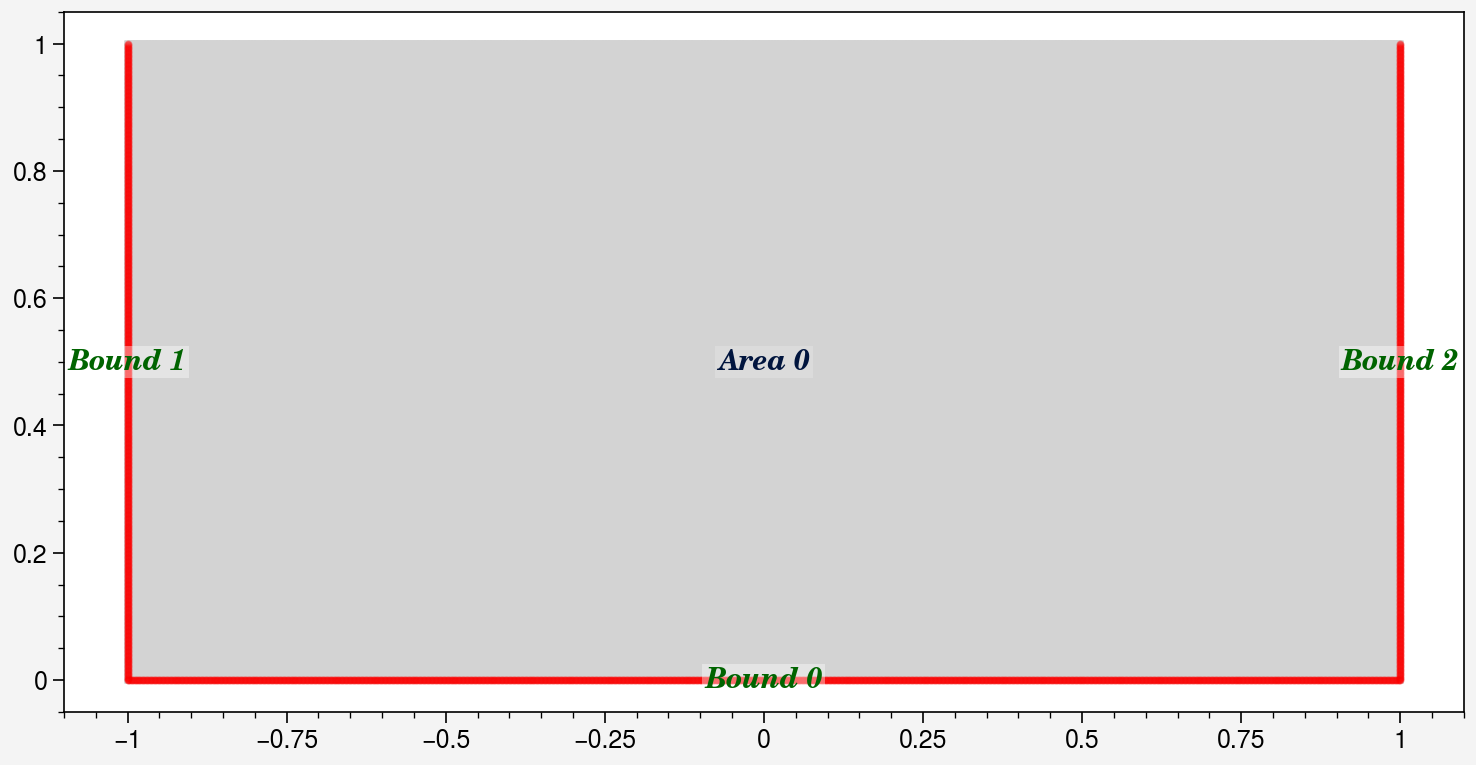

In [2]:
area = df.geometry.rectangle([-1, 1], [0, 1])
line_ic = df.geometry.line_horizontal(y=0, range_x=[-1,1])
line_bc1 = df.geometry.line_vertical(x=-1, range_y=[0,1])
line_bc2 = df.geometry.line_vertical(x=1, range_y=[0,1])
domain = df.domain(area.area_list, line_ic, line_bc1, line_bc2)
domain.show_setup()

## 2. Define Physics
Define the Burgers eq (spatial version) apply boundary conditions.

In [3]:
# Define PDE
from torch import sin, pi
domain.area_list[0].define_pde(df.pde.BurgersEquation1D(nu=0.01/pi))
domain.bound_list[0].define_bc({'u':['x', lambda x: -sin(pi * x)]})
domain.bound_list[1].define_bc({'u': 0})
domain.bound_list[2].define_bc({'u': 0})

### 2. Generate Training Data

Sample initial points for training. After sampling, Deepflow will automatically generate training datasets based on the defined physics.

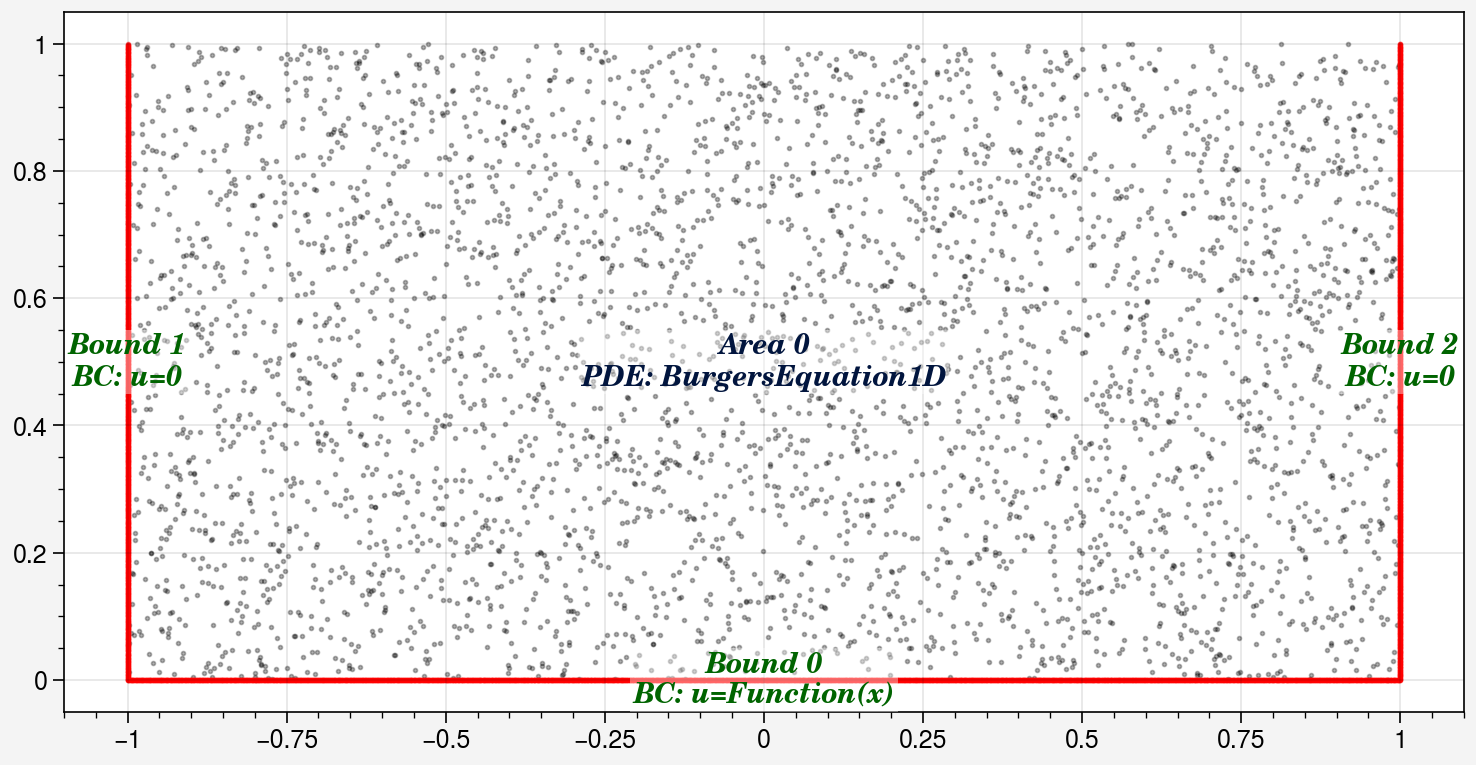

In [4]:
# Sample points: [Left, Bottom, Right, Top], [Interior]
domain.sampling_lhs([2000, 1000, 1000], [4000])
domain.show_coordinates(display_physics=True)

### 3. Train the Model

Define the resampling scheme during training. [R3](https://arxiv.org/abs/2207.02338) scheme is recommended.

In [5]:
def do_in_adam(epoch, model):
    if epoch % 500 == 0 and epoch > 0:
        domain.sampling_R3([2000, 1000, 1000], [4000])
        print(domain)
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3([2000, 1000, 1000], [4000])
        print(domain)

Train the model using Adam optimizer followed by L-BFGS optimizer.

In [6]:
model0 = df.PINN(input_vars=['x', 'y'], output_vars=['u'], width=16, length=4)

model1, model1_best = model0.train_adam(
    calc_loss = df.calc_loss_simple(domain),
    learning_rate=0.015,
    epochs=4000,
    do_between_epochs=do_in_adam)

Epoch: 1, total_loss: 0.63708, bc_loss: 0.63691, pde_loss: 0.00018
Epoch: 200, total_loss: 0.10178, bc_loss: 0.05901, pde_loss: 0.04277
Epoch: 400, total_loss: 0.07294, bc_loss: 0.04452, pde_loss: 0.02842
number of bound : ['0: 3065', '1: 1693', '2: 1482']
number of area : ['0: 5407']
Epoch: 600, total_loss: 0.10885, bc_loss: 0.07805, pde_loss: 0.03080
Epoch: 800, total_loss: 0.01511, bc_loss: 0.00641, pde_loss: 0.00870
Epoch: 1000, total_loss: 0.01650, bc_loss: 0.00472, pde_loss: 0.01178
number of bound : ['0: 3800', '1: 2198', '2: 1813']
number of area : ['0: 6625']
Epoch: 1200, total_loss: 0.01325, bc_loss: 0.00356, pde_loss: 0.00969
Epoch: 1400, total_loss: 0.00802, bc_loss: 0.00367, pde_loss: 0.00435
number of bound : ['0: 4617', '1: 2747', '2: 2254']
number of area : ['0: 7925']
Epoch: 1600, total_loss: 0.00648, bc_loss: 0.00290, pde_loss: 0.00358
Epoch: 1800, total_loss: 0.00302, bc_loss: 0.00102, pde_loss: 0.00201
Epoch: 2000, total_loss: 0.00735, bc_loss: 0.00360, pde_loss: 0.

In [7]:
model2 = model1_best.train_lbfgs(calc_loss = df.calc_loss_simple(domain), epochs=500, do_between_epochs=do_in_lbfgs)

Epoch: 3945, total_loss: 0.00049, bc_loss: 0.00009, pde_loss: 0.00041
Epoch: 3995, total_loss: 0.00002, bc_loss: 0.00000, pde_loss: 0.00002
Training interrupted by user.


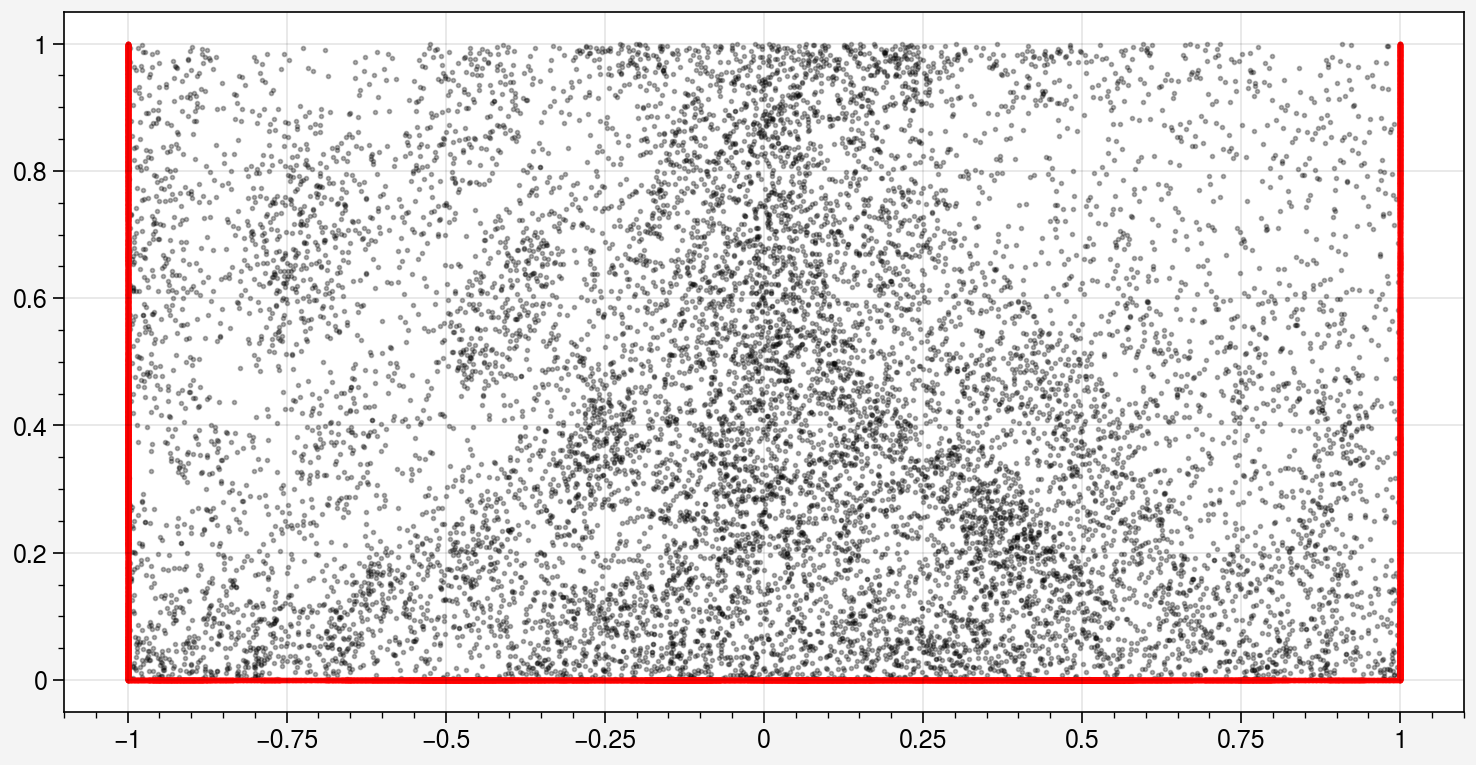

In [8]:
domain.show_coordinates(display_physics=False)

## 4. Visualization

In [22]:
# Evaluate the best model
prediction = domain.area_list[0].evaluate(model2)
# Sampling uniform points
prediction.sampling_area([500, 250])

### 4.1 Visualize PDE area

C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UltraPlotWarning: Tick label sharing not implemented for <class 'ultraplot.axes.three.ThreeAxes'> subplots.
  func(*args, **kwargs)


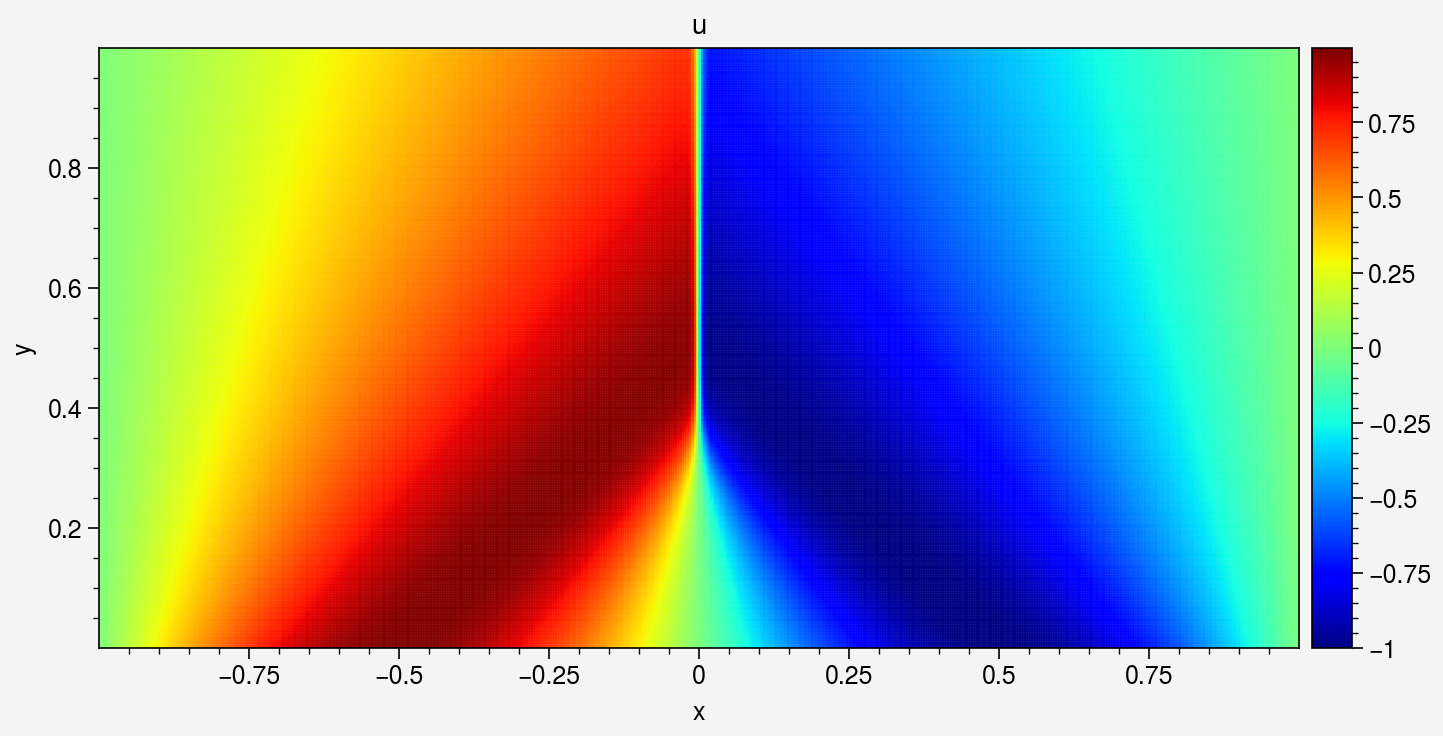

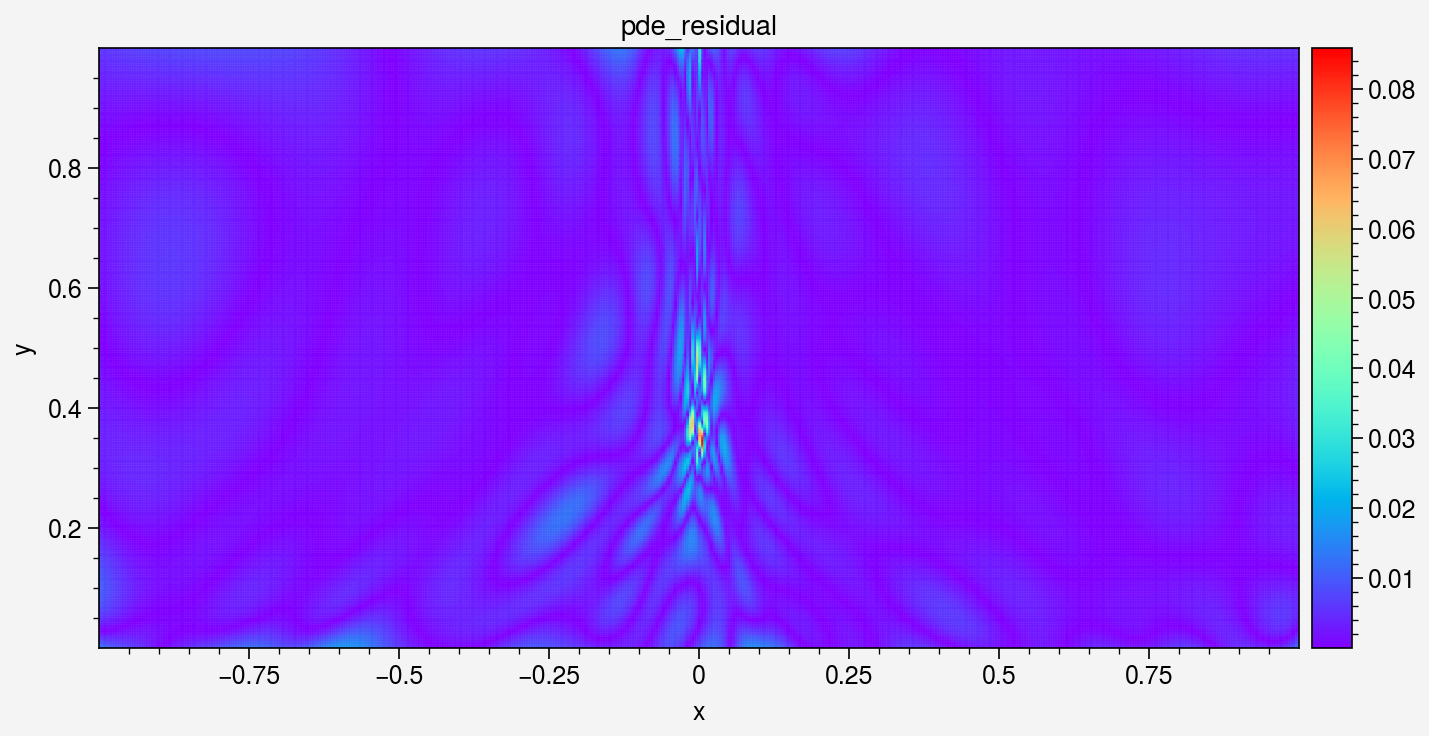

C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UltraPlotWarning: Tick label sharing not implemented for <class 'ultraplot.axes.three.ThreeAxes'> subplots.
  fig.canvas.print_figure(bytes_io, **kw)


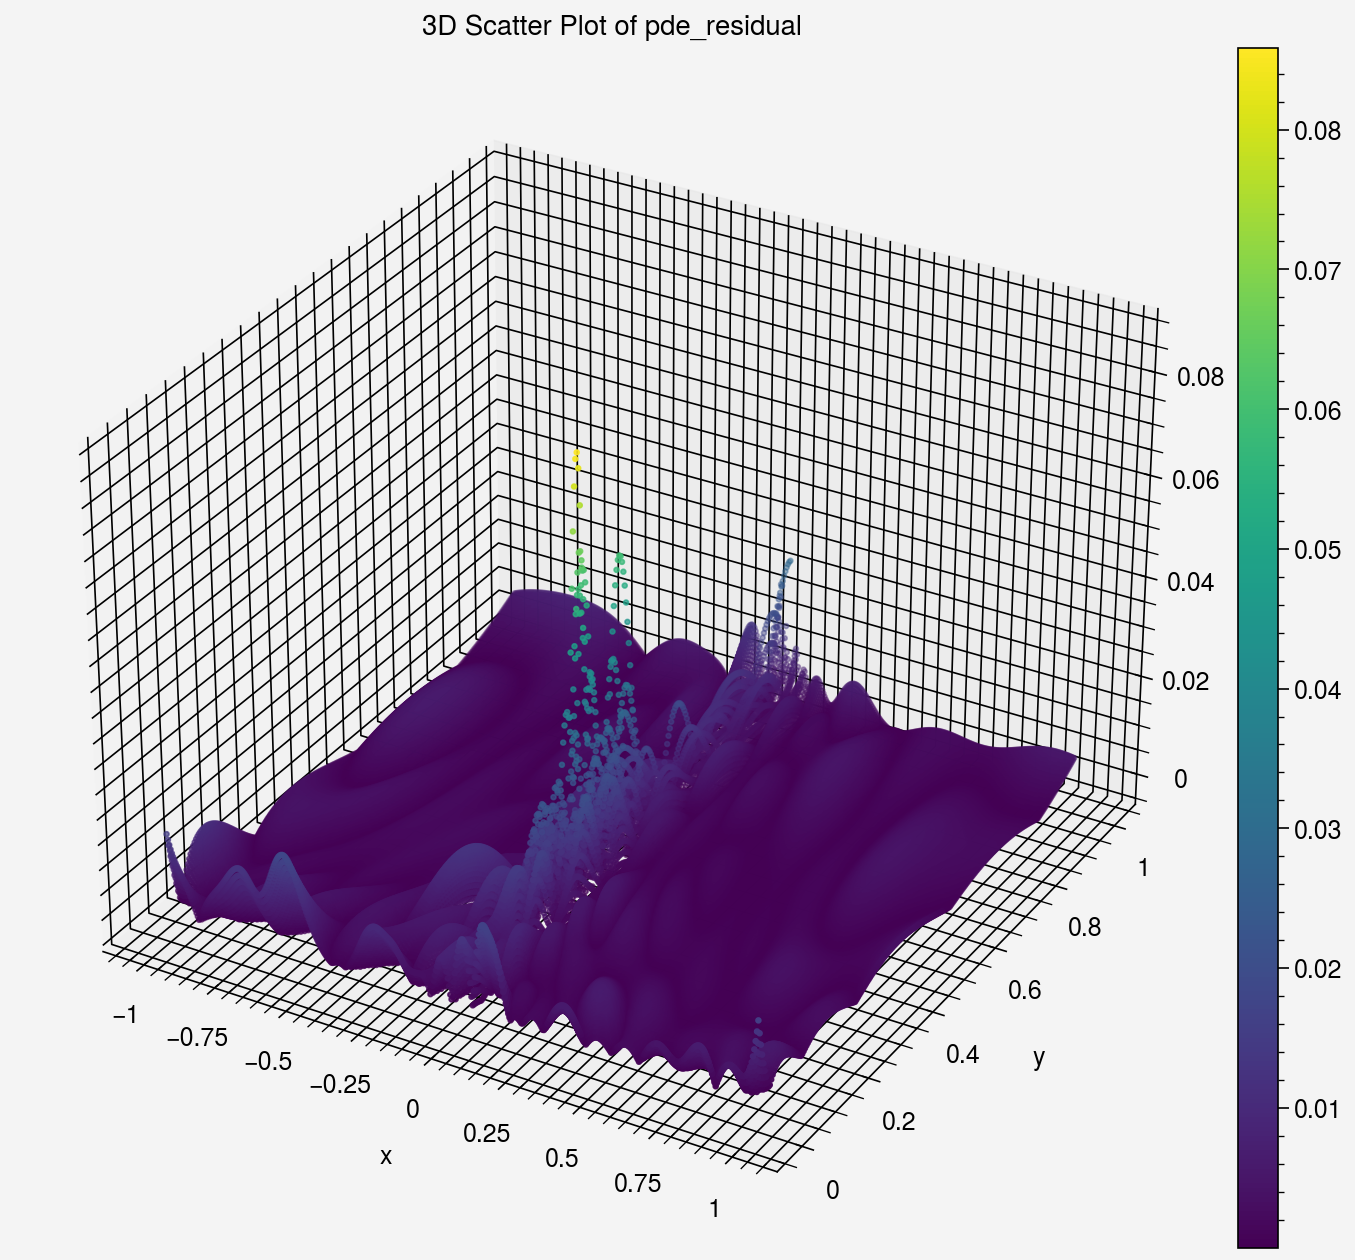

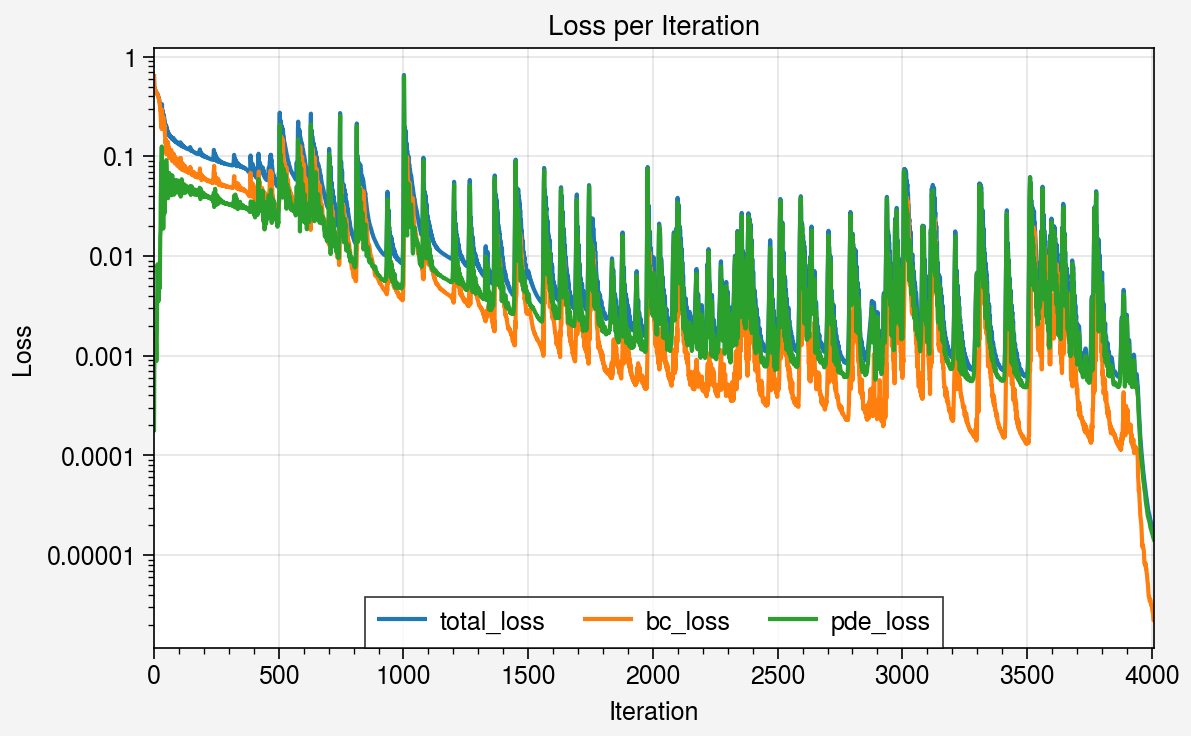

In [27]:
# Plot Velocity Field
prediction.plot_color('u', cmap = 'jet', s=0.3).savefig('u_field.png')
_ = prediction.plot_color('pde_residual', cmap = 'rainbow', s=0.3)
_ = prediction.plot('pde_residual')
_ = prediction.plot_loss_curve(log_scale=True)

### 4.2 Visualize u at y = 0.75

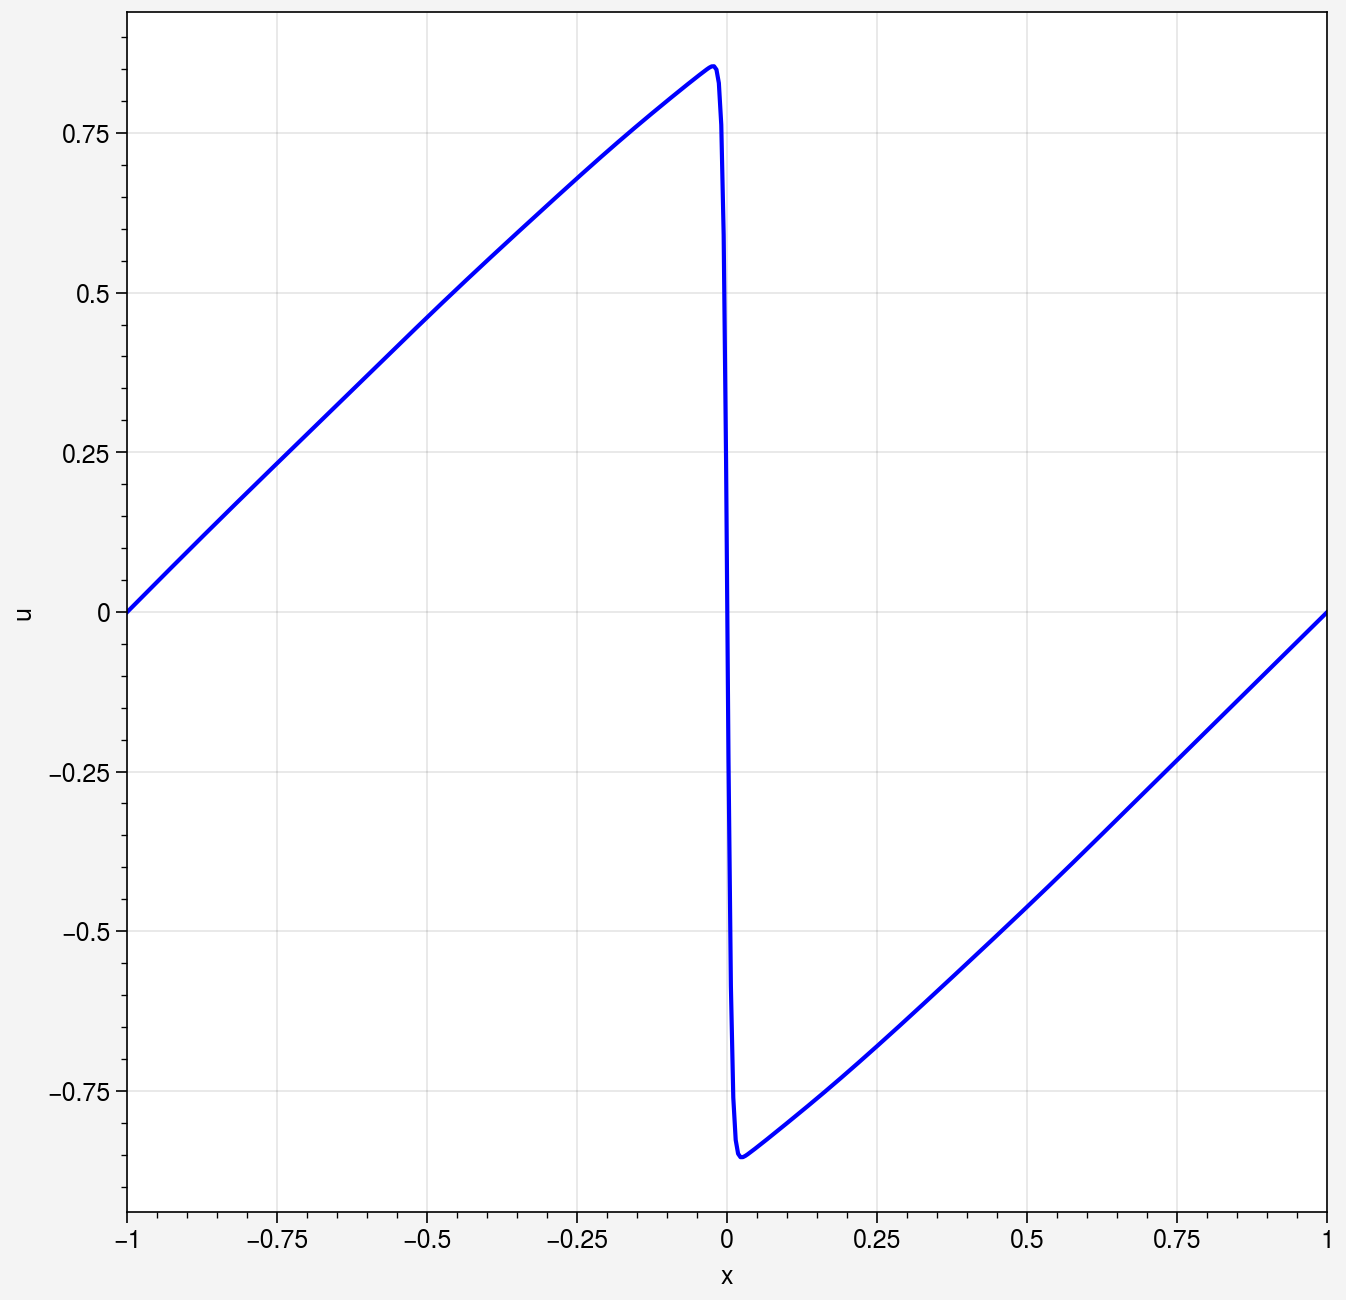

In [17]:
line = df.geometry.line_horizontal(y=0.75, range_x=[-1, 1])
prediction = line.evaluate(model2)
prediction.sampling_line(500)
_ = prediction.plot(y_axis = 'u')